In [3]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import glob
import os
import ipywidgets as widgets
from IPython.display import clear_output
import sys
import time
import json
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import seaborn as sns
import fnmatch
# ASTROPHY Imports
import astropy 
from astropy.table import Table
from astropy.io import fits
from sherpa.astro import ui
# CIAO Imports
import ciao_contrib.runtool
from ciao_contrib.runtool import *
# CUSTOM Imports
from data_extraction_functions import *
from data_exploration_functions import *
from data_representation_functions import *

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Custom object hook to convert lists of lists to NumPy arrays
def numpy_hook(obj):
    if isinstance(obj, list):
        # Check if the list contains sublists (i.e. a matrix)
        if isinstance(obj[0], list):
            # Convert the list of lists to a NumPy array matrix
            return np.array(obj)
    # Return all other objects as is
    return obj

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[0],description='Set :',disabled=False); set_widget


Dropdown(description='Set :', options=('Full', 'All', 'New', 'Bona'), value='Full')

In [11]:
# Set ID
set_id = set_widget.value
# Load properties
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')
df_properties_global = pd.read_csv(f'{global_path}/{set_id}/properties-{set_id}.csv')
df_properties_global['obsreg_id'] = df_properties_global['obsid'].astype(str) + '_' + df_properties_global['region_id'].astype(str)
df_properties = df_properties_input.drop_duplicates('obsreg_id', keep='first').reset_index()
ids = list(df_properties['obsreg_id'].values)
df_results = df_properties_global[df_properties_global['obsreg_id'].isin(ids)]
print("Number of Property Sets: ", len(df_properties))
df_sources = df_results.groupby(['name','ra','dec']).count()
df_sources = df_sources.rename(columns={'obsreg_id': 'counts'}).reset_index()
print("Number of Sources: ", len(df_sources))
print('Average Number of Observations per Source: ', len(df_properties)/len(df_sources))
ra = df_sources.ra.values
dec = df_sources.dec.values
counts = df_sources.counts.values



df_properties_input_old = pd.read_csv(f'{global_path}/All/properties-input-All.csv')
df_properties_global_old = pd.read_csv(f'{global_path}/All/properties-All.csv')
df_properties_global_old['obsreg_id'] = df_properties_global_old['obsid'].astype(str) + '_' + df_properties_global_old['region_id'].astype(str)
df_results_old = df_properties_global_old[df_properties_global_old['obsreg_id'].isin(ids)]
df_sources_old = df_results_old.groupby(['name','ra','dec']).count()
df_sources_old = df_sources_old.rename(columns={'obsreg_id': 'counts'}).reset_index()
print("Number of Sources (Old): ", len(df_sources_old))
ra_old = df_sources.ra.values
dec_old = df_sources.dec.values
counts_old = df_sources.counts.values

df_sources.head()


Number of Property Sets:  95473
Number of Sources:  58932
Average Number of Observations per Source:  1.6200536211226497
Number of Sources (Old):  45785


,name,ra,dec,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,significance,likelihood_class,conf_flag,sat_src_flag,...,hard_hs_hilim,var_prob_b,var_prob_h,var_prob_m,var_prob_s,var_index_b,var_index_w,livetime,detector,counts
0,2CXO J000000.5-575830,0.002735,-57.975181,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,1
1,2CXO J000002.4+004444,0.010189,0.745732,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,1
2,2CXO J000002.4+321750,0.010280,32.297465,1,1,1,1,1,1,1,...,1,1,1,1,0,1,0,1,1,1
3,2CXO J000002.9-350332,0.012314,-35.059185,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,1
4,2CXO J000004.2+004038,0.017437,0.677247,1,1,1,1,1,1,1,...,1,1,1,1,0,1,0,1,1,1


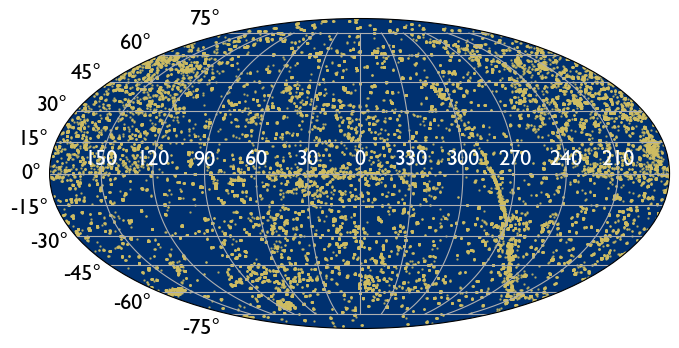

In [16]:
# Define Font Settings
plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Gill Sans'
dark = '#003170'
bright = '#cfbd62'
# Plotting in Mollweide projection
fig, ax = plt.subplots(1,1,subplot_kw={'projection': 'mollweide'}, figsize=(8, 5))

org = 0
x = np.remainder(ra+360-org,360) # shift RA values
ind = x>180
x[ind] -=360    # scale conversion to [-180, 180]
ra2=-x    # reverse the scale: East to the left
tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360+org,360)
ax.set_xticklabels(tick_labels) 

scatter = ax.scatter(np.radians(ra2), np.radians(dec),c=bright, s=0.5, alpha=0.75) 


# org_old = 0
# x_old = np.remainder(ra_old+360-org_old,360) # shift RA values
# ind_old = x_old>180
# x_old[ind_old] -=360    # scale conversion to [-180, 180]
# ra2_old=-x_old    # reverse the scale: East to the left
# tick_labels_old = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
# tick_labels_old = np.remainder(tick_labels_old+360+org_old,360)
# ax.set_xticklabels(tick_labels_old) 

# scatter2 = ax.scatter(np.radians(ra2_old), np.radians(dec_old),c='red', s=0.7, alpha=1) 




ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='black')
# ax.xaxis.grid(color='white', linestyle='-', alpha=0.55)
# ax.yaxis.grid(color='white', linestyle='-', alpha=0.55)
ax.set_facecolor(dark)
ax.grid(True)

plt.show()


/var/folders/q1/jbx7qj7s0dxbh7nv02nfvc680000gn/T/ipykernel_6326/2550105418.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  scatter = ax.scatter(np.radians(ra2), np.radians(dec),c=bright, s=0.5, alpha=0.75, cmap = 'cividis',norm=LogNorm())


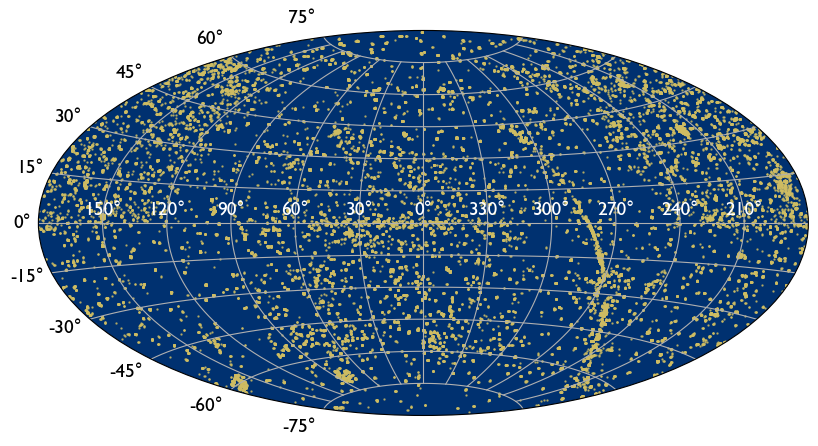

In [116]:
# Define Font Settings
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Gill Sans'
dark = '#003170'
bright = '#cfbd62'
gr = '#777777'
# Plotting in Mollweide projection
fig, ax = plt.subplots(1,1,subplot_kw={'projection': 'aitoff'}, figsize=(40, 5))
org = 0
x = np.remainder(ra+360-org,360) # shift RA values
ind = x>180
x[ind] -=360    # scale conversion to [-180, 180]
ra2=-x    # reverse the scale: East to the left
tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360+org,360)

ytick_labels = np.array([90, 75, 60, 45, 30, 15, 0, -15, -30, -45, -60, -75, -90])

degree_sign= u'\N{DEGREE SIGN}'
tick_labels  = [str(i) + degree_sign for i in tick_labels ]
ytick_labels = [str(i) + degree_sign for i in ytick_labels ]

scatter = ax.scatter(np.radians(ra2), np.radians(dec),c=bright, s=0.5, alpha=0.75, cmap = 'cividis',norm=LogNorm()) 
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='black')
ax.set_xticklabels(tick_labels) 

# ax.xaxis.grid(color='white', linestyle='-', alpha=0.55)
# ax.yaxis.grid(color='white', linestyle='-', alpha=0.55)
ax.set_facecolor(dark)
ax.grid(True)

plt.show()

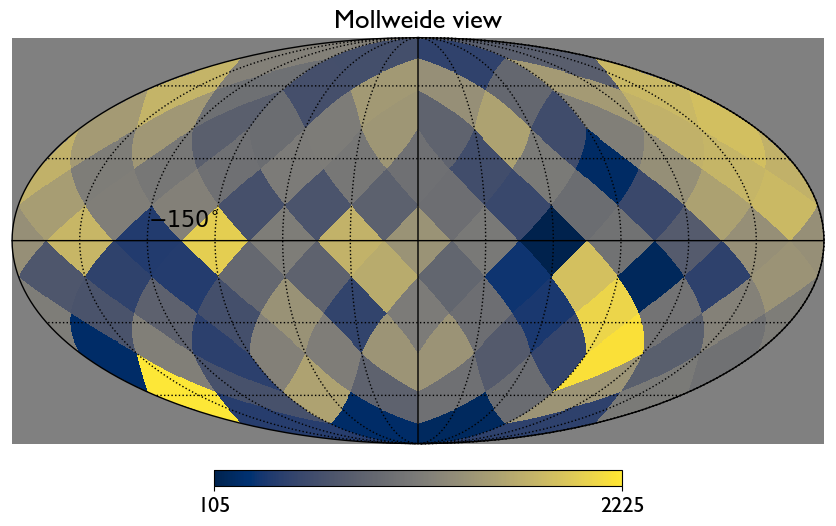

In [54]:
from astropy.coordinates import SkyCoord
import healpy as hp

def cat2hpx(ra, dec, nside, radec=True):
    """
    Convert a catalogue to a HEALPix map of number counts per resolution
    element.

    Parameters
    ----------
    lon, lat : (ndarray, ndarray)
        Coordinates of the sources in degree. If radec=True, assume input is in the icrs
        coordinate system. Otherwise assume input is glon, glat

    nside : int
        HEALPix nside of the target map

    radec : bool
        Switch between R.A./Dec and glon/glat as input coordinate system.

    Return
    ------
    hpx_map : ndarray
        HEALPix map of the catalogue number counts in Galactic coordinates

    """

    npix = hp.nside2npix(nside)

    l, b = ra, dec

    # conver to theta, phi
    theta = np.radians(90-b)
    phi = np.radians(l)

    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)

    idx, counts = np.unique(indices, return_counts=True)

    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts

    return hpx_map

nside = 3
hpx_map = cat2hpx(ra, dec, nside, radec=True)
hp.mollview(hpx_map, unit="", rot=(0,0,0), cmap='cividis', flip='astro',return_projected_map=True,norm=LogNorm())
hp.projtext(-150-90,5, '$-150^{\circ}$', lonlat=True)

# hp.projtext(180, 30, '$30^{\circ}$', lonlat=True)
# hp.projtext(180, 0, '$0^{\circ}$', lonlat=True)
# hp.projtext(180, -60, '$-60^{\circ}$', lonlat=True)
# hp.projtext(180, -30, '$-30^{\circ}$', lonlat=True)
# hp.projtext(0, 0, '$0^{\circ}$', lonlat=True)
# hp.projtext(30, 0, '$30^{\circ}$', lonlat=True)
# hp.projtext(60, 0, '$60^{\circ}$', lonlat=True)
# hp.projtext(90, 0, '$90^{\circ}$', lonlat=True)
# hp.projtext(120, 0, '$120^{\circ}$', lonlat=True)
# hp.projtext(150, 0, '$150^{\circ}$', lonlat=True)
# hp.projtext(179, 0, '$180^{\circ}$', lonlat=True)
# hp.projtext(0, 0, '$0^{\circ}$', lonlat=True)
# hp.projtext(210, 0, '$210^{\circ}$', lonlat=True)
# hp.projtext(240, 0, '$240^{\circ}$', lonlat=True)
# hp.projtext(270, 0, '$270^{\circ}$', lonlat=True)
# hp.projtext(300, 0, '$300^{\circ}$', lonlat=True)
# hp.projtext(330, 0, '$330^{\circ}$', lonlat=True)
hp.graticule()
